# **Forecasting Temperature with `Skforecast`**

**Main goal of the project:** 
>***Forecasting temperature in a accurate way using a Machine Learning general approach.***

  This part of the project will be focused in the following forecasting approaches: 

  - Univariate forecasting with recursive and direct forecasting strategies.

  - Multivariate forecasting  with recursive forecasting strategy.

  - Multiple forecasting with recursive forecasting strategy.

For each approach the best model will be found, applying ML evaluation techniques like cross Validation and hyper-parameter optimization.

**Author:** ***Fabio Scielzo Ortiz***

### **Requirements**

In [1]:
import polars as pl 
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import datetime
import warnings
warnings.filterwarnings("ignore")
import optuna
from PIL import Image
import pickle
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg 
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import ElasticNet

In [ ]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series')
from PyTS import MakeLags, SARIMA, SimpleExpSmooth, VAR, LinearRegressionTS, KNeighborsRegressorTS, wape, absolute_r2, train_test_split_time_series, OptunaSearchTSCV, time_series_multi_plot, get_prediction_dates, predictive_time_series_plot, KFold_split_time_series, KFold_score_time_series, KFold_time_series_plot, autoSARIMA, DecisionTreeRegressorTS, ExtraTreesRegressorTS, RandomForestRegressorTS, HistGradientBoostingRegressorTS,  MLPRegressorTS, LinearSVRTS, XGBRegressorTS, RidgeTS, LassoTS, ElasticNetTS, StackingRegressorTS, BaggingRegressorTS, OutliersImputer, outliers_time_series_plot

In [ ]:
sys.path.insert(0, 'C:/Users/fscielzo/Documents/DataScience-GitHub/EDA')
from EDA import prop_cols_nulls

## `Skforecast`

Allows Univariate, Multivariate and Multiple Forecasting, and both recursive and direct forecasting strategies.

- Univariate - Recursive and Direct -  Forecasting.

- Multivariate and Multiple  - Recursive - Forecasting.

- Based on Sklearn and Statmodels implementations.

- Provides method for model validation and hyper-parameter optimization.



## **Data**

### **Conceptual description**

Jena Climate is weather time series dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

This dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

The dataset can be found in `Kaggle`: https://www.kaggle.com/datasets/mnassrib/jena-climate

| Variable Name | Description | Type |
|----------|----------|----------|
| `Date Time`    |Date-time reference | Date   |
| `p (mbar)`    | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.  | quantitative  |
| `T (degC)`   |  Temperature in Celsius  |  quantitative  |
|  `Tpot (K)`   |  Temperature in Kelvin  |  quantitative  |
| `Tdew (degC)` |   Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.  |  quantitative  |
| `rh (%)`   |  Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.  | quantitative  |
|  `VPmax (mbar)`  |  Saturation vapor pressure | quantitative  |
|  `VPact (mbar)`   |  Vapor pressure   |  quantitative  |
| `	VPdef (mbar)`   | Vapor pressure deficit   | quantitative   |
|  `sh (g/kg)`  |  Specific humidity | quantitative  |
|   `H2OC (mmol/mol)`      | Water vapor concentration   | quantitative  |
| `rho (g/m ** 3)`   | Airtight | quantitative   |
| `wv (m/s)`   |  Wind speed  |  quantitative  |
| `max. wv (m/s)`  |  Maximum wind speed |  quantitative  |
|  `wd (deg)`  |  Wind direction in degrees  |  quantitative  |


### **Preprocessing the data**

The next piece of code read the data, rename their columns, change the date column to an appropriate date format, ad columns with the day, week, month, quarter and year of each observation and remove the last row which is the only point related with 2017.

In [4]:
climate_df = pl.read_csv(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\Data\jena_climate_2009_2016.csv')

climate_df.columns = ['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 
                      'sh', 'H2OC', 'rho', 'wv', 'max_wv', 'wd']

climate_df = climate_df.with_columns(pl.col("date").str.to_date("%d.%m.%Y %H:%M:%S").name.keep())

climate_df = climate_df.with_columns(climate_df['date'].dt.day().alias('day'),
                        climate_df['date'].dt.month().alias('month'),
                        climate_df['date'].dt.year().alias('year'),
                        climate_df['date'].dt.week().alias('week'),
                        climate_df['date'].dt.quarter().alias('quarter'))

climate_df = climate_df[:-1,:] # removing last row, just because is the only data point regarding 2017

The data has 420550 rows and 20 columns.

In [5]:
climate_df.shape

(420550, 20)

We print a head and tail of the data.

In [6]:
climate_df.head()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2009-01-01,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1,1,2009,1,1
2009-01-01,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1,1,1,2009,1,1
2009-01-01,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6,1,1,2009,1,1
2009-01-01,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0,1,1,2009,1,1
2009-01-01,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3,1,1,2009,1,1


In [7]:
climate_df.tail()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2016-12-31,1000.11,-3.93,269.23,-8.09,72.6,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.0,202.6,31,12,2016,52,4
2016-12-31,1000.07,-4.05,269.1,-8.13,73.1,4.52,3.3,1.22,2.06,3.3,1292.98,0.67,1.52,240.0,31,12,2016,52,4
2016-12-31,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,31,12,2016,52,4
2016-12-31,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.0,215.2,31,12,2016,52,4
2016-12-31,999.81,-4.23,268.94,-8.53,71.8,4.46,3.2,1.26,1.99,3.2,1293.56,1.49,2.16,225.8,31,12,2016,52,4


We make a fast descriptive summary of the data.

In [8]:
climate_df.describe()

describe,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""420550""",420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,989.212751,9.450181,283.492779,4.955886,76.00826,13.576273,9.533771,4.042419,6.022418,9.640238,1216.062557,1.702225,3.056558,174.743714,15.713359,6.51732,2012.496802,26.617729,2.506375
"""std""",null,8.358475,8.423346,8.504449,6.730651,16.476195,7.739016,4.184158,4.896855,2.656135,4.235388,39.975064,65.446792,69.017014,86.681794,8.799074,3.448315,2.289752,15.060659,1.116766
"""min""","""2009-01-01""",913.6,-23.01,250.6,-25.01,12.95,0.95,0.79,0.0,0.5,0.8,1059.45,-9999.0,-9999.0,0.0,1.0,1.0,2009.0,1.0,1.0
"""25%""",null,984.2,3.36,277.43,0.24,65.21,7.78,6.21,0.87,3.92,6.29,1187.49,0.99,1.76,124.9,8.0,4.0,2010.0,14.0,2.0
"""50%""",null,989.58,9.42,283.47,5.22,79.3,11.82,8.86,2.19,5.59,8.96,1213.79,1.76,2.96,198.1,16.0,7.0,2012.0,27.0,3.0
"""75%""",null,994.72,15.47,289.53,10.07,89.4,17.6,12.35,5.3,7.8,12.49,1242.77,2.86,4.74,234.1,23.0,10.0,2014.0,40.0,4.0
"""max""","""2016-12-31""",1015.35,37.28,311.34,23.11,100.0,63.77,28.32,46.01,18.13,28.82,1393.54,28.49,23.5,360.0,31.0,12.0,2016.0,53.0,4.0


There is an anomaly in the variable `wv`, since the minimum value of it is -9999 when it should be a positive variable since is measure in m/s. We are going to clean this anomaly (error) substituting this value by the mean of the variable.

Naturally, this anomaly has been transmitted to `max_wv`, so, we will clean this variable as well.

In [9]:
climate_df = climate_df.with_columns(
                        pl.when(pl.col('wv') == pl.col('wv').min())
                        .then(pl.col('wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('wv'))  # Keeps original value when condition is False
                        .alias('wv')  # Rename the resulting column back to 'variable'
                    )

climate_df = climate_df.with_columns(
                        pl.when(pl.col('max_wv') == pl.col('max_wv').min())
                        .then(pl.col('max_wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('max_wv'))  # Keeps original value when condition is False
                        .alias('max_wv')  # Rename the resulting column back to 'variable'
                    )

In [10]:
# climate_df.write_csv(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\Data\jena_climate_cleaned.csv')

Checking if the last transformation has solved the anomaly completely.

In [11]:
climate_df.min()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2009-01-01,913.6,-23.01,250.6,-25.01,12.95,0.95,0.79,0.0,0.5,0.8,1059.45,0.0,0.0,0.0,1,1,2009,1,1


Checking if there are missing values.

In [12]:
prop_cols_nulls(climate_df)

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that there are non missing values in the data, which is specially important.

In [13]:
''''
# If the data would have missing values, a way to fill them could be this:

climate_df = climate_df.fill_null(strategy="forward") # fill NaN's with the previous values 
climate_df = climate_df.fill_null(strategy="backward") # fill NaN's with the later values 
'''

'\'\n# If the data would have missing values, a way to fill them could be this:\n\nclimate_df = climate_df.fill_null(strategy="forward") # fill NaN\'s with the previous values \nclimate_df = climate_df.fill_null(strategy="backward") # fill NaN\'s with the later values \n'

## **Daily time series**

In this section we are going to compute the daily time series for the series with which we are going to work.

In [14]:
df = {}
variables_forecasting = ['T', 'rh', 'VPact', 'H2OC', 'wv', 'max_wv', 'wd', 'p']
for col in variables_forecasting:
    df[col] = climate_df.group_by(['year', 'month', 'day']).agg(pl.col(col).mean()).sort(['year', 'month', 'day'])
    df[col] = df[col].with_columns((pl.col("day").cast(str) + '-' + pl.col("month").cast(str) + '-' + pl.col("year").cast(str)).alias("date"))
    df[col] = df[col].with_columns(pl.col("date").str.to_date("%d-%m-%Y").name.keep())

In [15]:
for col in variables_forecasting:
    print('--------------------------------------')
    print(f'head-tail of {col}')

    display(df[col].head(3))
    display(df[col].tail(3))

--------------------------------------
head-tail of T


year,month,day,T,date
i32,i8,i8,f64,date
2009,1,1,-6.810629,2009-01-01
2009,1,2,-3.728194,2009-01-02
2009,1,3,-5.271736,2009-01-03


year,month,day,T,date
i32,i8,i8,f64,date
2016,12,29,2.67625,2016-12-29
2016,12,30,-1.706597,2016-12-30
2016,12,31,-2.4925,2016-12-31


--------------------------------------
head-tail of rh


year,month,day,rh,date
i32,i8,i8,f64,date
2009,1,1,91.086014,2009-01-01
2009,1,2,92.086806,2009-01-02
2009,1,3,76.458056,2009-01-03


year,month,day,rh,date
i32,i8,i8,f64,date
2016,12,29,90.384722,2016-12-29
2016,12,30,92.927083,2016-12-30
2016,12,31,74.360694,2016-12-31


--------------------------------------
head-tail of VPact


year,month,day,VPact,date
i32,i8,i8,f64,date
2009,1,1,3.355524,2009-01-01
2009,1,2,4.267292,2009-01-02
2009,1,3,3.107708,2009-01-03


year,month,day,VPact,date
i32,i8,i8,f64,date
2016,12,29,6.705833,2016-12-29
2016,12,30,5.048542,2016-12-30
2016,12,31,3.765069,2016-12-31


--------------------------------------
head-tail of H2OC


year,month,day,H2OC,date
i32,i8,i8,f64,date
2009,1,1,3.357832,2009-01-01
2009,1,2,4.26875,2009-01-02
2009,1,3,3.111944,2009-01-03


year,month,day,H2OC,date
i32,i8,i8,f64,date
2016,12,29,6.613542,2016-12-29
2016,12,30,4.996875,2016-12-30
2016,12,31,3.749444,2016-12-31


--------------------------------------
head-tail of wv


year,month,day,wv,date
i32,i8,i8,f64,date
2009,1,1,0.778601,2009-01-01
2009,1,2,1.419514,2009-01-02
2009,1,3,1.250903,2009-01-03


year,month,day,wv,date
i32,i8,i8,f64,date
2016,12,29,0.837986,2016-12-29
2016,12,30,1.138125,2016-12-30
2016,12,31,0.803403,2016-12-31


--------------------------------------
head-tail of max_wv


year,month,day,max_wv,date
i32,i8,i8,f64,date
2009,1,1,1.378252,2009-01-01
2009,1,2,2.227361,2009-01-02
2009,1,3,2.065069,2009-01-03


year,month,day,max_wv,date
i32,i8,i8,f64,date
2016,12,29,1.394028,2016-12-29
2016,12,30,1.839306,2016-12-30
2016,12,31,1.453542,2016-12-31


--------------------------------------
head-tail of wd


year,month,day,wd,date
i32,i8,i8,f64,date
2009,1,1,181.863077,2009-01-01
2009,1,2,125.072014,2009-01-02
2009,1,3,190.383333,2009-01-03


year,month,day,wd,date
i32,i8,i8,f64,date
2016,12,29,196.642639,2016-12-29
2016,12,30,201.359028,2016-12-30
2016,12,31,194.592153,2016-12-31


--------------------------------------
head-tail of p


year,month,day,p,date
i32,i8,i8,f64,date
2009,1,1,999.145594,2009-01-01
2009,1,2,999.600625,2009-01-02
2009,1,3,998.548611,2009-01-03


year,month,day,p,date
i32,i8,i8,f64,date
2016,12,29,1013.957569,2016-12-29
2016,12,30,1010.460278,2016-12-30
2016,12,31,1004.476181,2016-12-31


Now we build a data frame with each one of the daily time series (just the values, not th dates).

In [16]:
df_multi = pl.concat([pl.DataFrame(df[col][col]) for col in variables_forecasting], how='horizontal')
df_multi

T,rh,VPact,H2OC,wv,max_wv,wd,p
f64,f64,f64,f64,f64,f64,f64,f64
-6.810629,91.086014,3.355524,3.357832,0.778601,1.378252,181.863077,999.145594
-3.728194,92.086806,4.267292,4.26875,1.419514,2.227361,125.072014,999.600625
-5.271736,76.458056,3.107708,3.111944,1.250903,2.065069,190.383333,998.548611
-1.375208,89.417361,4.938958,4.997014,1.720417,3.564861,213.069861,988.510694
-4.867153,86.260417,3.806736,3.847778,3.800278,5.94,118.287361,990.405694
-15.482847,83.774722,1.5425,1.547083,1.226806,2.097708,156.915486,997.052986
-15.734375,85.659722,1.720972,1.731458,0.7225,1.483333,161.920486,993.506389
-9.609167,87.582639,2.601181,2.593542,0.870208,1.443611,182.944444,1002.969653
-12.301458,83.97625,2.019653,2.013819,0.663819,1.237778,166.947917,1003.113333


### **Plotting**

In this section we are going to plot all the considered time series as a multi-plot.

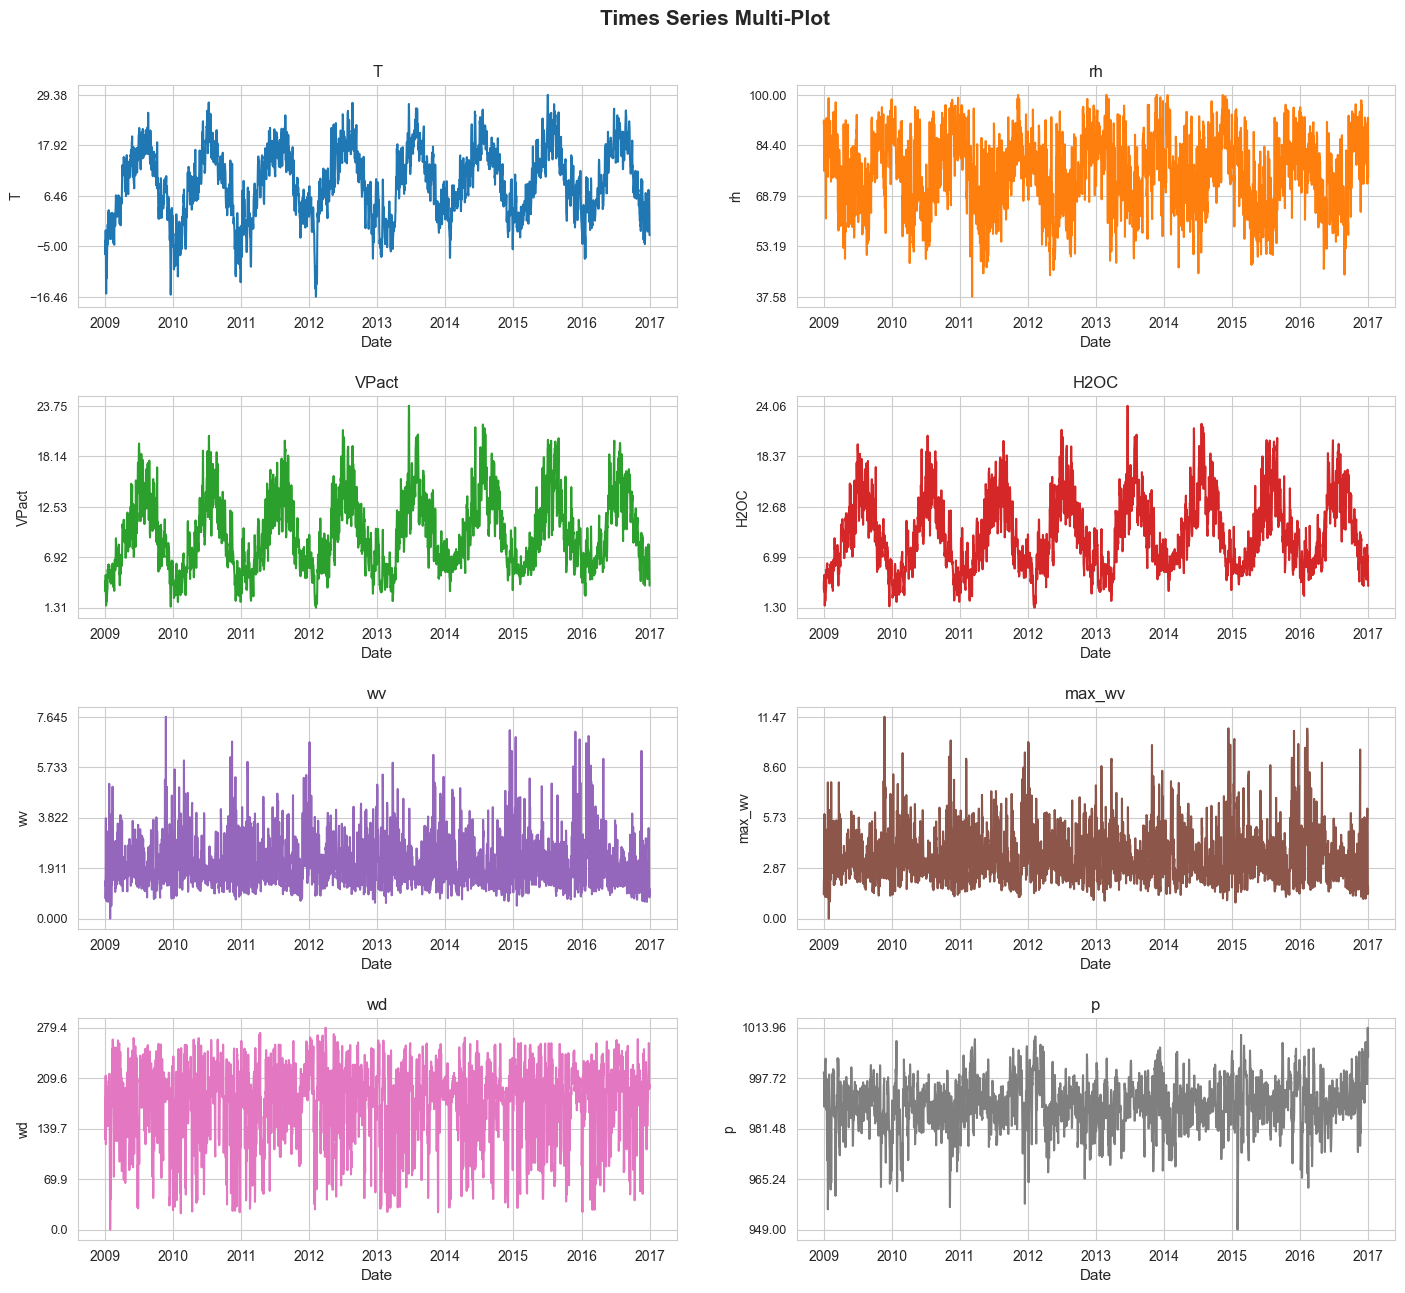

In [17]:
time_series_multi_plot(df=df, n_cols=2, figsize=(17, 15), title='Times Series Multi-Plot', 
                       titles_size=15, title_height=0.93, 
                       subtitles_size=12, hspace=0.4, wspace=0.2)

## **Forecasting workflow**

In this section we are going to use the `Skforecast` framework, a Python library that eases using `Scikit-learn` regressors as single and multi-step forecasters.

The main goal of this section is to look for the best approach to forecast the temperature in Jena (`T`) 15 days ahead,using tools already provided by `Skforecast`.

Since `Skforecast` allows us to use univariate, multivariate and multiple forecasting, the first one with recursive and direct strategies, we ware going to explore all these alternatives.

### **Predictors and response definition**

In [18]:
############################################################################
# For univariate forecasting
############################################################################

Y, X = {}, {}
for col in variables_forecasting: 
    Y[col] = df[col][col].to_pandas() # Data must be a pandas series to work with Skforecast
    # Fake X for skforecast implementations
    X[col] = np.zeros((len(Y[col]), 4))

############################################################################
# For multiple forecasting  
############################################################################
    
variables_multi = {0: ['T', 'rh', 'wv'], # type 0
                   1: variables_forecasting  # type 1
                   }
X_multi = {}
for var_type in variables_multi.keys():
    X_multi[var_type] = pd.DataFrame({col: Y[col] for col in variables_multi[var_type]})

### **Outer evaluation definition: Time Series Train-Test Split**

For the outer evaluation we are going to use a train-test split.

The train partition will be used in the inner evaluation to select the best alternative, and the test partition in the outer to estimate the best model future performance.

We will use a test window of 15 days, that is the length of the test partition.

In [19]:
# Defining the test_window (in terms of days)
outer_test_window = 15

In [20]:
X_train, X_test, Y_train, Y_test, X_multi_train, X_multi_test = {}, {}, {}, {}, {}, {}

for col in variables_forecasting:
    
    X_train[col], X_test[col], Y_train[col], Y_test[col] = train_test_split_time_series(X=X[col], y=Y[col], 
                                                                                        test_window=outer_test_window,
                                                                                        framework='Skforecast')

for var_type in variables_multi.keys():

    X_multi_train[var_type], X_multi_test[var_type], _, _ = train_test_split_time_series(X=X_multi[var_type], y=Y['T'], # y is not relevant in this case
                                                                     test_window=outer_test_window,
                                                                     framework='Skforecast')

### **Inner evaluation definition: Times Series Cross Validation**

In the inner evaluation we will use KFold CV for time series, with 10 splits (K) and a test window of 15 days.  

The style of the KFold CV that we are going to apply along this project is illustrated in the following graph:

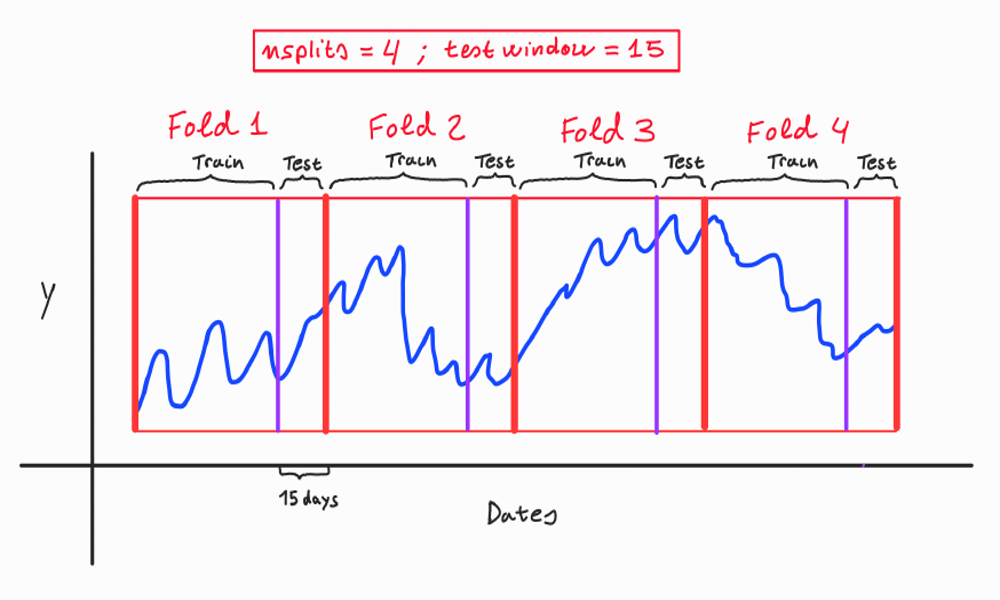

In [27]:
Image.open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\images\p9.png').resize((1000, 600)).convert("RGB")

We define the  number of splits as 10 and the test window as 15 days.

In [26]:
n_splits = 10 
inner_test_window = 15

### **Inner evaluation: HPO**

We are going to apply HPO to the Top-4 models according to the forecasting analysis with `PyTS` (another notebook) , following univariate (direct and recursive) , multivariate and multiple forecasting approaches, using `Skforecast`.

Those top-4 models are: 

- Random Forest
- ElasticNet
- Trees
- SVM


#### **Grids definition**

In this section we are going to define the grids for each one of the above models.


- Grid for Random Forest

In [ ]:
# Grid for Random Forest
def param_grid_RF(trial):

    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 120),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 25),
        'lags': trial.suggest_categorical('lags', [20, 30, 40])
    }

    return param_grid

- Grid for Trees

In [ ]:
# Grid for trees
def param_grid_trees(trial):

    param_grid = {
        'max_depth': trial.suggest_categorical('max_depth', [None, 2, 5, 7, 10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 25),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
        'lags': trial.suggest_categorical('lags', [20, 30, 40])
    }

    return param_grid

- Grid for Linear SVM

In [ ]:
# Grid for Linear SVM
def param_grid_linear_SVM(trial):

    param_grid = {
        'epsilon': trial.suggest_categorical('epsilon', [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5]),
        'C': trial.suggest_categorical('C', [0.1, 0.7, 1, 5, 10, 20, 50, 100]),
        'lags': trial.suggest_categorical('lags', [20, 30, 40])
    }

    return param_grid

- Grid for ElasticNet

In [ ]:
# Grid for ElasticNet
def param_grid_elastic_net(trial):

    # Specific logic for Lasso
    param_grid = {
        'alpha': trial.suggest_float('alpha', 0.1, 10, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.1, 0.9, step=0.02),
        'lags': trial.suggest_categorical('lags', [20, 30, 40])
    }

    return param_grid

#### **Applying HPO**

In this section we are going to apply HPO on the above models.

We will explore  **univariate (recursive and direct strategy)**, **multivariate** and **multiple** approach to forecast the **temperature** in Jena `(T)`. 


We are going to find the best hyper-parameter combination for each alternative.

**Important:** in the multivariate and multiple approaches we will explore two sets of variables, type 0   `('T', 'rh', 'wv')` and type 1 `('T', 'rh', 'VPact', 'H2OC', 'wv', 'max_wv', 'wd', 'p')`. 

Another thing to mention is that we are not going to do an exhaustive search in the univariate direct, multivariate and multiple cases, specially in the for Random Forest, due to its prohibitive computational cost.

In general we have realized that univariate with direct strategy, multivariate and multiple are much more expensive forecasting approaches than univariate with recursive strategy. 

The ranking of the most computationally demanding approaches is;

1. Univariate with direct forecasting strategy

2. Multivariate

3. Multiple

4. Univariate wit recursive forecasting strategy

In [ ]:
best_score, best_params, inner_results = {}, {}, {}

- **Random Forest - univariate - recursive** forecasting approach

In [ ]:
estimator = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=20)
param_grid = param_grid_RF
n_iter = 150
series_name = 'T'
model_name = 'RF_uni_recursive_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='Skforecast', approach='univariate')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **Random Forest - univariate - direct** forecasting approach

In [ ]:
estimator = ForecasterAutoregDirect(regressor=RandomForestRegressor(random_state=123), lags=20, steps=inner_test_window)
param_grid = param_grid_RF
n_iter = 25
series_name = 'T'
model_name = 'RF_uni_direct_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **Random Forest - multivariate - recursive** forecasting approach

In [ ]:
series_name = 'T'
estimator = ForecasterAutoregMultiVariate(regressor=RandomForestRegressor(random_state=123), 
                                          lags=20, steps=inner_test_window, level=series_name) # level is the name of the variable to forecast   
param_grid = param_grid_RF
n_iter = 15

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast', approach='multivariate'
                                     )

for var_type in variables_multi.keys():
    print(var_type)

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name]) # X is the relevant object in this case

    model_name = f'RF_multivariate(var_type={var_type})_Skfc'

    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()


- **Random Forest - multiple - recursive** forecasting approach


In [ ]:
estimator = ForecasterAutoregMultiSeries(regressor=RandomForestRegressor(random_state=123), lags=20)                                  
param_grid = param_grid_RF
n_iter = 50
series_name = 'T'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window, level=series_name, # level uis used to indicate which variable to forecast
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast', approach='multiple'
                                     )

for var_type in variables_multi.keys():
    print(var_type)

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name]) # X is the relevant object in this case

    model_name = f'RF_multiple(var_type={var_type})_Skfc'

    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()

---

- **Trees - univariate - recursive** forecasting approach

In [ ]:
estimator = ForecasterAutoreg(regressor=DecisionTreeRegressorTS(random_state=123), lags=20)
param_grid = param_grid_trees
n_iter = 500
series_name = 'T'
model_name = 'Trees_uni_recursive_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='Skforecast', approach='univariate')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **Trees - univariate - direct** forecasting approach

In [ ]:
estimator = ForecasterAutoregDirect(regressor=DecisionTreeRegressorTS(random_state=123), lags=20, steps=inner_test_window)
param_grid = param_grid_trees
n_iter = 150
series_name = 'T'
model_name = 'Trees_uni_direct_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **Trees - multivariate - recursive** forecasting approach

In [ ]:
series_name = 'T'
estimator = ForecasterAutoregMultiVariate(regressor=DecisionTreeRegressorTS(random_state=123), 
                                          lags=20, steps=inner_test_window, level=series_name)   
param_grid = param_grid_trees
n_iter = 75

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast', approach='multivariate'
                                     )

for var_type in variables_multi.keys():

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name])

    model_name = f'Trees_multivariate(var_type={var_type})_Skfc'

    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()


- **Trees - multiple - recursive** forecasting approach

In [ ]:
estimator = ForecasterAutoregMultiSeries(regressor=DecisionTreeRegressorTS(random_state=123), lags=20)                                  
param_grid = param_grid_trees
n_iter = 275
series_name = 'T'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window, level=series_name,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast', approach='multiple'
                                     )

for var_type in variables_multi.keys():

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name])

    model_name = f'Trees_multiple(var_type={var_type})_Skfc'
    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()

---

- **SVM - univariate - recursive** forecasting approach

In [ ]:
estimator = ForecasterAutoreg(regressor=LinearSVR(), lags=20)
param_grid = param_grid_linear_SVM
n_iter = 500
series_name = 'T'
model_name = 'SVM_uni_recursive_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='Skforecast', approach='univariate')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **SVM - univariate - direct** forecasting approach

In [ ]:
estimator = ForecasterAutoregDirect(regressor=LinearSVR(), lags=20, steps=inner_test_window)
param_grid = param_grid_linear_SVM
n_iter = 250
series_name = 'T'
model_name = 'SVM_uni_direct_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **SVM - multivariate - recursive** forecasting approach


In [ ]:
series_name = 'T'
estimator = ForecasterAutoregMultiVariate(regressor=LinearSVR(), 
                                          lags=20, steps=inner_test_window, level=series_name)   
param_grid = param_grid_linear_SVM
n_iter = 300

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast', approach='multivariate'
                                     )

for var_type in variables_multi.keys():

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name])

    model_name = f'SVM_multivariate(var_type={var_type})_Skfc'
    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()


- **SVM - multiple - recursive** forecasting approach

In [ ]:
estimator = ForecasterAutoregMultiSeries(regressor=LinearSVR(), lags=20)                                  
param_grid = param_grid_linear_SVM
n_iter = 300
series_name = 'T'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window, level=series_name,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=666, kfold_verbose=False,
                                     framework='Skforecast', approach='multiple'
                                     )

for var_type in variables_multi.keys():

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name])

    model_name = f'SVM_multiple(var_type={var_type})_Skfc'
    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()

---

- **ElasticNet - univariate - recursive** forecasting approach

In [ ]:
estimator = ForecasterAutoreg(regressor=ElasticNet(), lags=20)
param_grid = param_grid_elastic_net
n_iter = 500
series_name = 'T'
model_name = 'ElasticNet_uni_recursive_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='Skforecast', approach='univariate')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **ElasticNet - univariate - direct** forecasting approach

In [ ]:
estimator = ForecasterAutoregDirect(regressor=ElasticNet(), lags=20, steps=inner_test_window)
param_grid = param_grid_elastic_net
n_iter = 200
series_name = 'T'
model_name = 'ElasticNet_uni_direct_Skfc'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast')

optuna_search.fit(X=X_train[series_name], y=Y_train[series_name])

best_params[model_name] = optuna_search.best_params_
best_score[model_name] = optuna_search.best_score_
inner_results[model_name] = optuna_search.results()

- **ElasticNet - multivariate - recursive** forecasting approach

In [ ]:
series_name = 'T'
estimator = ForecasterAutoregMultiVariate(regressor=ElasticNet(), 
                                          lags=20, steps=inner_test_window, level=series_name)   
param_grid = param_grid_elastic_net
n_iter = 200

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=111, kfold_verbose=False,
                                     framework='Skforecast', approach='multivariate'
                                     )

for var_type in variables_multi.keys():

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name])

    model_name = f'ElasticNet_multivariate(var_type={var_type})_Skfc'
    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()


- **ElasticNet - multiple - recursive** forecasting approach

In [ ]:
estimator = ForecasterAutoregMultiSeries(regressor=ElasticNet(), lags=20)                                  
param_grid = param_grid_elastic_net
n_iter = 500
model_name = 'ElasticNet_multiple_Skfc'
series_name = 'T'

optuna_search = OptunaSearchTSCV(estimator=estimator, param_grid=param_grid, 
                                     n_splits=n_splits, test_window=inner_test_window, level=series_name,
                                     scoring=wape, direction='minimize', 
                                     n_iter=n_iter, random_state=123, kfold_verbose=False,
                                     framework='Skforecast', approach='multiple'
                                     )

for var_type in variables_multi.keys():

    optuna_search.fit(X=X_multi_train[var_type], y=Y_train[series_name])

    model_name = f'ElasticNet_multiple(var_type={var_type})_Skfc'
    best_params[model_name] = optuna_search.best_params_
    best_score[model_name] = optuna_search.best_score_
    inner_results[model_name] = optuna_search.results()

---

**Saving the results:**

In [ ]:
# Saving the results as pickle files
'''
with open(f'results/inner_results_skforecast', 'wb') as file:
    pickle.dump(inner_results, file)

with open(f'results/best_params_skforecast', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'results/best_score_skforecast', 'wb') as file:
    pickle.dump(best_score, file)
'''

**Opening the results:**

In [23]:
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\inner_results_skforecast', 'rb') as file:
        inner_results = pickle.load(file)

with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\best_params_skforecast', 'rb') as file:
        best_params = pickle.load(file)

with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\best_score_skforecast', 'rb') as file:
        best_score = pickle.load(file)

### **Inner evaluation: selecting the best model**

In this section we are going to plot the obtained results regarding the inner score of the tried models and select the best one, that is, the one with less inner WAPE.

In [24]:
model_names = np.array(list(best_score.keys()))
inner_scores_values = np.array(list(best_score.values()))
best_model = model_names[np.argmin(inner_scores_values)]
score_best_model = np.min(inner_scores_values)

combined_models_score = list(zip(model_names, inner_scores_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_models, sorted_scores = zip(*sorted_combined_models_score)
sorted_models, sorted_scores = list(sorted_models), list(sorted_scores)

not_multi_methods = [x for x in model_names if 'uni' in x]
multivariate_methods = [x for x in model_names if 'multivariate' in x]
multiple_methods = [x for x in model_names if 'multiple' in x]

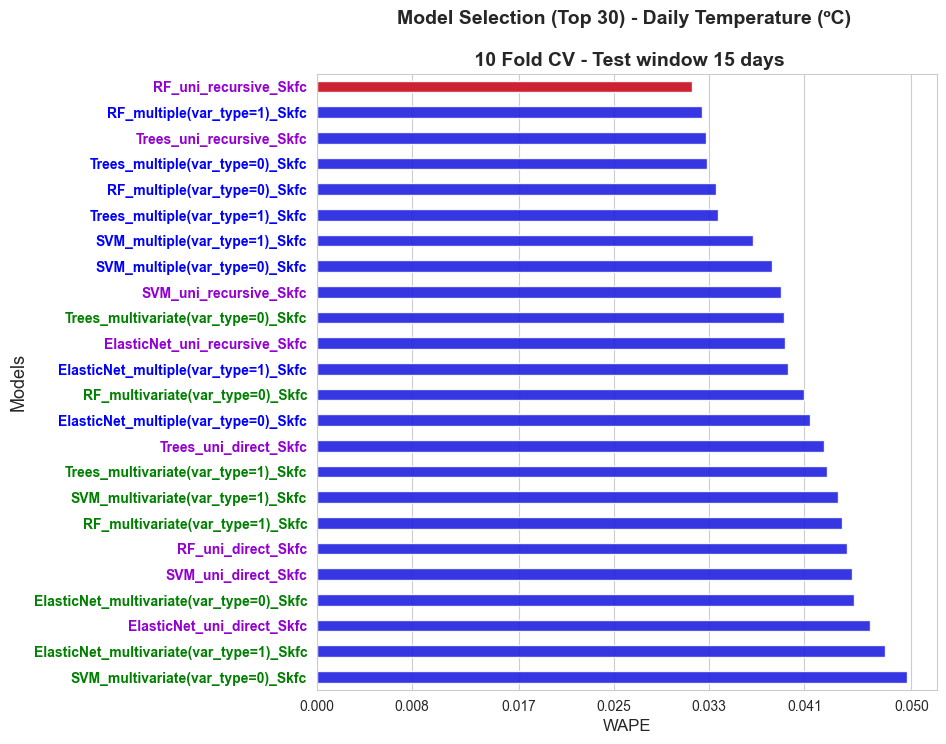

In [28]:
top = 30 

fig, axes = plt.subplots(figsize=(8,8))

ax = sns.barplot(y=sorted_models[0:top], x=sorted_scores[0:top], color='blue', width=0.45, alpha=0.9)
ax = sns.barplot(y=[best_model], x=[score_best_model], color='red', width=0.45, alpha=0.9)

ax.set_ylabel('Models', size=13)
ax.set_xlabel('WAPE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(sorted_scores[0:top]), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Model Selection (Top {top}) - Daily Temperature (ºC) \n\n {n_splits} Fold CV - Test window {inner_test_window} days', size=14, weight='bold')

for label in ax.get_yticklabels():
    if label.get_text() in not_multi_methods:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in multivariate_methods:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in multiple_methods:
        label.set_weight('bold')
        label.set_color('blue') 

plt.show()

The best model is Random Forest with 20 lags and the following hyper-parameters:

In [29]:
best_params[best_model]

{'n_estimators': 78,
 'max_depth': 3,
 'min_samples_split': 2,
 'min_samples_leaf': 23,
 'lags': 20}

The complete dictionary of models-score is the following:

In [30]:
best_score

{'RF_uni_recursive_Skfc': 0.03153206503215547,
 'RF_uni_direct_Skfc': 0.04459728069159734,
 'RF_multivariate(var_type=0)_Skfc': 0.040987526506390384,
 'RF_multivariate(var_type=1)_Skfc': 0.04418304812985149,
 'RF_multiple(var_type=0)_Skfc': 0.033549782162254654,
 'RF_multiple(var_type=1)_Skfc': 0.03236979156553439,
 'Trees_uni_recursive_Skfc': 0.03276672414697664,
 'Trees_uni_direct_Skfc': 0.042685618799419726,
 'Trees_multivariate(var_type=0)_Skfc': 0.03928647229788469,
 'Trees_multivariate(var_type=1)_Skfc': 0.04295090068178306,
 'Trees_multiple(var_type=0)_Skfc': 0.03282195305421333,
 'Trees_multiple(var_type=1)_Skfc': 0.03375588947883306,
 'SVM_uni_recursive_Skfc': 0.03901666754897505,
 'SVM_uni_direct_Skfc': 0.04499416369445969,
 'SVM_multivariate(var_type=0)_Skfc': 0.049673808772747484,
 'SVM_multivariate(var_type=1)_Skfc': 0.043867820572245454,
 'SVM_multiple(var_type=0)_Skfc': 0.038314369321531455,
 'SVM_multiple(var_type=1)_Skfc': 0.036679922822074086,
 'ElasticNet_uni_recursi

### **Outer evaluation: estimation of future performance**

Estimation of future performance of the best model, that is, the performance of the best model of this section predicting the test set.

In [31]:
regressor_params = {key: value for key, value in best_params[best_model].items() if key != 'lags'}

best_estimator = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123).set_params(**regressor_params), lags=best_params[best_model]['lags'])

In [33]:
series_name = 'T'
best_estimator.fit(y=Y_train[series_name])
Y_test_hat = best_estimator.predict(steps=outer_test_window)
future_performance = wape(y_pred=Y_test_hat, y_true=Y_test[series_name])
future_performance

0.06647348600430844

### **Outer evaluation: visualization**


In this section we display a plot to visualize how the best model performs in the testing set.

In the plot we can see the last part of the original series along with the predictions of the best model for the test partition (outer test window of 15 days) as well as for the upcoming 15 days (forecasting window).

In [34]:
forecast_window = 15

In [35]:
# Resources to plot test and future forecast

best_estimator.fit(y=Y_train[series_name])
Y_test_hat = best_estimator.predict(steps=inner_test_window)

best_estimator.fit(y=Y[series_name])
Y_future_hat = best_estimator.predict(steps=forecast_window)

Y_hat = {}
Y_hat[best_model] = np.concatenate((Y_test_hat, Y_future_hat))
predicted_values = Y_hat

dates = df['T']['date'].to_numpy()
prediction_dates = get_prediction_dates(dates, inner_test_window, forecast_window)

future_performance = {best_model: future_performance}

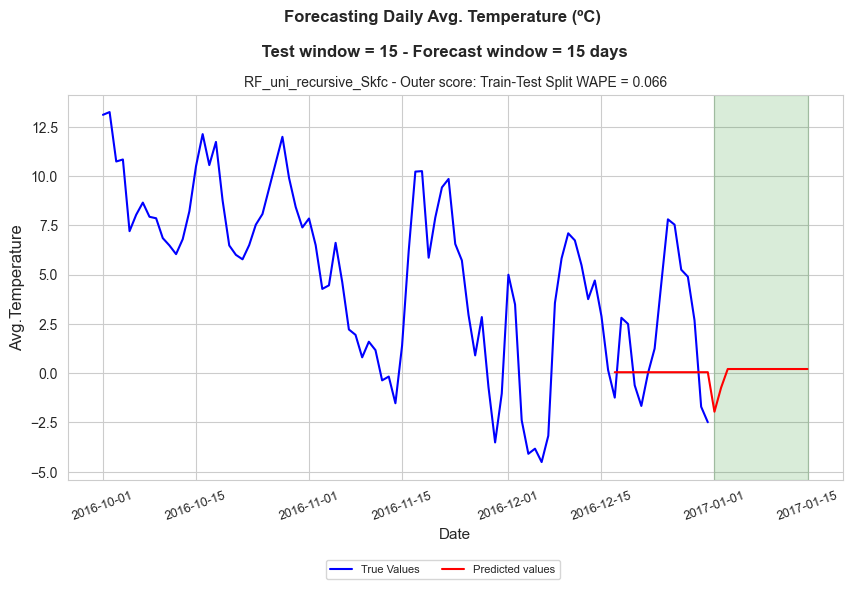

In [36]:
# Plotting test and future forecast
predictive_time_series_plot(n_cols=1, figsize=(10,5), 
                            data=df['T'].filter(pl.col('year')==2016, pl.col('month').is_in([10, 11, 12])), 
                            x_name='date', y_name='T', true_color='blue', pred_color='red',
                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=outer_test_window, 
                            scores=future_performance, score_name='Outer score: Train-Test Split WAPE',
                            title=f"Forecasting Daily Avg. Temperature (ºC)\n\n Test window = {outer_test_window} - Forecast window = {forecast_window} days", 
                            title_size=12, title_weight='bold', subtitles_size=10,
                            marker='', markersize=5, ylabel='Avg.Temperature', xlabel='Date',
                            xticks_size=9, hspace=0.7, wspace=0.13, xticks_rotation=20, xlabel_size=11, ylabel_size=11,
                            title_height=1.05, shadow_alpha=0.15, shadow_color='green', legend_size=8, bbox_to_anchor=(0.5,-0.1))


### **Predictive visualization of the top models**

Here we reproduce the previous plot but for the top-4 models and showing their inner scores as well, since were the ones used to sort them in terms of forecasting error.

In [43]:
Y_hat = {}
top = 4
model_names = sorted_models[0:top]


In [44]:
model_names

['RF_uni_recursive_Skfc',
 'RF_multiple(var_type=1)_Skfc',
 'Trees_uni_recursive_Skfc',
 'Trees_multiple(var_type=0)_Skfc']

In [45]:
regressor_params, estimators = {}, {}

In [46]:
for name in model_names: 

    regressor_params[name] = {key: value for key, value in best_params[name].items() if key != 'lags'}


In [57]:

estimators['RF_uni_recursive_Skfc'] = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123).set_params(**regressor_params['RF_uni_recursive_Skfc']), 
                                      lags=best_params['RF_uni_recursive_Skfc']['lags'])

estimators['RF_multiple(var_type=1)_Skfc'] = ForecasterAutoregMultiSeries(regressor=RandomForestRegressor(random_state=123).set_params(**regressor_params['RF_multiple(var_type=1)_Skfc']), 
                                                                          lags=best_params['RF_multiple(var_type=1)_Skfc']['lags'])        

estimators['Trees_uni_recursive_Skfc'] = ForecasterAutoreg(regressor=DecisionTreeRegressorTS(random_state=123).set_params(**regressor_params['Trees_uni_recursive_Skfc']), 
                                      lags=best_params['Trees_uni_recursive_Skfc']['lags'])

estimators['Trees_multiple(var_type=0)_Skfc'] = ForecasterAutoregMultiSeries(regressor=DecisionTreeRegressorTS(random_state=123).set_params(**regressor_params['Trees_multiple(var_type=0)_Skfc']), 
                                      lags=best_params['Trees_multiple(var_type=0)_Skfc']['lags'])

In [51]:
estimators['RF_uni_recursive_Skfc'].fit(y=Y_train[series_name])
Y_test_hat = estimators['RF_uni_recursive_Skfc'].predict(steps=inner_test_window)

estimators['RF_uni_recursive_Skfc'].fit(y=Y[series_name])
Y_future_hat = estimators['RF_uni_recursive_Skfc'].predict(steps=outer_test_window)

Y_hat['RF_uni_recursive_Skfc'] = np.concatenate((Y_test_hat, Y_future_hat))

In [68]:
var_type = 1 

estimators['RF_multiple(var_type=1)_Skfc'].fit(series=X_multi_train[var_type])
Y_test_hat = estimators['RF_multiple(var_type=1)_Skfc'].predict(steps=inner_test_window, levels=series_name)

estimators['RF_multiple(var_type=1)_Skfc'].fit(series=X_multi[var_type])
Y_future_hat = estimators['RF_multiple(var_type=1)_Skfc'].predict(steps=outer_test_window, levels=series_name)

Y_hat['RF_multiple(var_type=1)_Skfc'] = np.concatenate((Y_test_hat, Y_future_hat)).flatten()

In [58]:
estimators['Trees_uni_recursive_Skfc'].fit(y=Y_train[series_name])
Y_test_hat = estimators['Trees_uni_recursive_Skfc'].predict(steps=inner_test_window)

estimators['Trees_uni_recursive_Skfc'].fit(y=Y[series_name])
Y_future_hat = estimators['Trees_uni_recursive_Skfc'].predict(steps=outer_test_window)

Y_hat['Trees_uni_recursive_Skfc'] = np.concatenate((Y_test_hat, Y_future_hat))

In [66]:
var_type = 0 

estimators['Trees_multiple(var_type=0)_Skfc'].fit(series=X_multi_train[var_type])
Y_test_hat = estimators['Trees_multiple(var_type=0)_Skfc'].predict(steps=inner_test_window, levels=series_name)

estimators['Trees_multiple(var_type=0)_Skfc'].fit(series=X_multi[var_type])
Y_future_hat = estimators['Trees_multiple(var_type=0)_Skfc'].predict(steps=outer_test_window, levels=series_name)

Y_hat['Trees_multiple(var_type=0)_Skfc'] = np.concatenate((Y_test_hat, Y_future_hat)).flatten()

In [69]:
Y_hat

{'RF_uni_recursive_Skfc': array([ 0.0453505 ,  0.0453505 ,  0.0453505 ,  0.0453505 ,  0.0453505 ,
         0.0453505 ,  0.0453505 ,  0.0453505 ,  0.0453505 ,  0.0453505 ,
         0.0453505 ,  0.0453505 ,  0.0453505 ,  0.0453505 ,  0.0453505 ,
        -1.95898456, -0.73826802,  0.20673804,  0.20673804,  0.20673804,
         0.20673804,  0.20673804,  0.20673804,  0.20673804,  0.20673804,
         0.20673804,  0.20673804,  0.20673804,  0.20673804,  0.20673804]),
 'RF_multiple(var_type=1)_Skfc': array([ 2.68663752,  2.68663752,  2.68663752,  2.68663752,  2.68663752,
         2.68663752,  2.68663752,  2.68663752,  2.68663752,  2.68663752,
         2.68663752,  2.68663752,  2.68663752,  2.68663752,  2.68663752,
        -4.63394342, -4.63394342, -4.63394342, -4.63394342, -4.63394342,
        -4.63394342, -4.63394342, -4.63394342, -4.63394342, -4.63394342,
        -4.63394342, -4.63394342, -4.63394342, -4.63394342, -4.63394342]),
 'Trees_uni_recursive_Skfc': array([ 0.06947917, -0.61690972,  

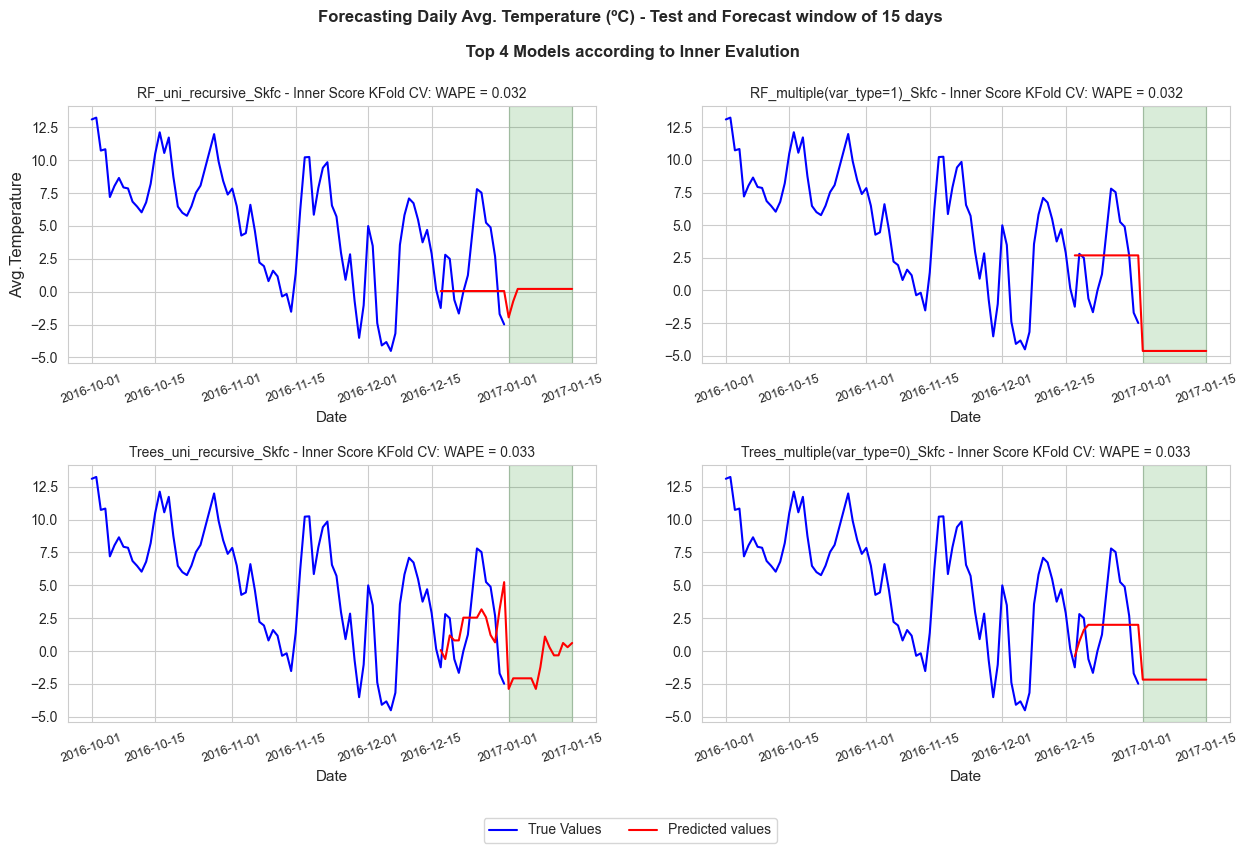

In [82]:
# Plotting test and future for the top models

predicted_values = Y_hat
prediction_dates = get_prediction_dates(dates, inner_test_window, forecast_window)

predictive_time_series_plot(n_cols=2, figsize=(15,8), 
                            data=df['T'].filter(pl.col('year')==2016, pl.col('month').is_in([10, 11, 12])), 
                            x_name='date', y_name='T', true_color='blue', pred_color='red',
                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=inner_test_window, 
                            scores=best_score, score_name='Inner Score KFold CV: WAPE',
                            title=f"Forecasting Daily Avg. Temperature (ºC) - Test and Forecast window of {forecast_window} days\n\n Top {top} Models according to Inner Evalution", 
                            title_size=12, title_weight='bold', subtitles_size=10,
                            marker='', markersize=5, ylabel='Avg.Temperature', xlabel='Date',
                            xticks_size=9, hspace=0.4, wspace=0.2, xticks_rotation=20, xlabel_size=11, ylabel_size=11,
                            title_height=1, shadow_alpha=0.15, shadow_color='green', legend_size=10, bbox_to_anchor=(0.5,-0.05))
